<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/master/XG_boost_EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [ ]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modos = [modo_1,modo_2,modo_3,modo_4,modo_5,residuo]

for i in modos:
  i["Fecha"] = pd.to_datetime(i["Fecha"],format='%Y-%m-%d')
  i.set_index("Fecha", inplace=True)

#modo_1["Fecha"] = pd.to_datetime(modo_1["Fecha"],format='%Y-%m-%d')
#modo_1.set_index("Fecha", inplace=True)

In [ ]:
type(modo_1.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='Fecha'>

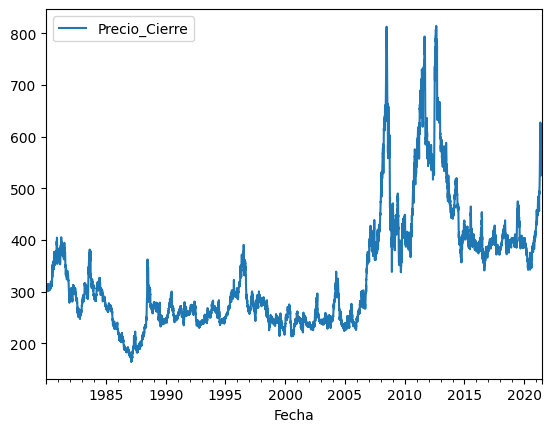

In [ ]:
datos_emd = modo_1+modo_2+modo_3+modo_4+modo_5+residuo
datos_emd = datos_emd.asfreq('D')
datos_emd.interpolate(inplace=True)
datos_emd.plot()

# Modelaremos el primer modo

In [ ]:
modo_1 = modo_1.asfreq('D')
modo_1.interpolate(inplace=True)


In [ ]:
def  create_features ( df ):
    """
    Crea características de series de tiempo basadas en el índice de series de tiempo.
    """
    df = df.copy()
    df[ 'diasemana' ] = df.index.dayofweek
    df[ 'trimestre' ] = df.index.quarter
    df[ 'mes' ] = df.index.month
    df[ 'año' ] = df.index.year
    df[ 'diadelaño' ] = df.index.dayofyear
    df[ 'diadelmes' ] = df.index.day
    df[ 'semanadelaño' ] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['Precio_Cierre'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df


In [ ]:
modo_1 = create_features(modo_1)
modo_1 = add_lags(modo_1)
modo_1.dropna(inplace=True)
modo_1.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-10.156557,4,2,6,2021,176,25,25,-3.966171,3.033792,1.709854
2021-06-26,-2.208231,5,2,6,2021,177,26,25,-10.702284,5.024402,2.687152
2021-06-27,5.740096,6,2,6,2021,178,27,25,-9.689751,-3.651857,-3.387535
2021-06-28,13.688422,0,2,6,2021,179,28,26,-8.677217,-5.057986,3.845341
2021-06-29,-13.343663,1,2,6,2021,180,29,26,-7.664684,-6.464116,1.468172


In [ ]:
modo_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14060 entries, 1983-01-01 to 2021-06-29
Freq: D
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  14060 non-null  float64
 1   diasemana      14060 non-null  int64  
 2   trimestre      14060 non-null  int64  
 3   mes            14060 non-null  int64  
 4   año            14060 non-null  int64  
 5   diadelaño      14060 non-null  int64  
 6   diadelmes      14060 non-null  int64  
 7   semanadelaño   14060 non-null  UInt32 
 8   lag1           14060 non-null  float64
 9   lag2           14060 non-null  float64
 10  lag3           14060 non-null  float64
dtypes: UInt32(1), float64(4), int64(6)
memory usage: 1.2 MB


In [ ]:
total_datos=len(modo_1.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_1[:division_entrenamiento]
datos_validacion = modo_1[division_entrenamiento:division_validacion]
datos_testeo = modo_1[division_validacion:total_datos]

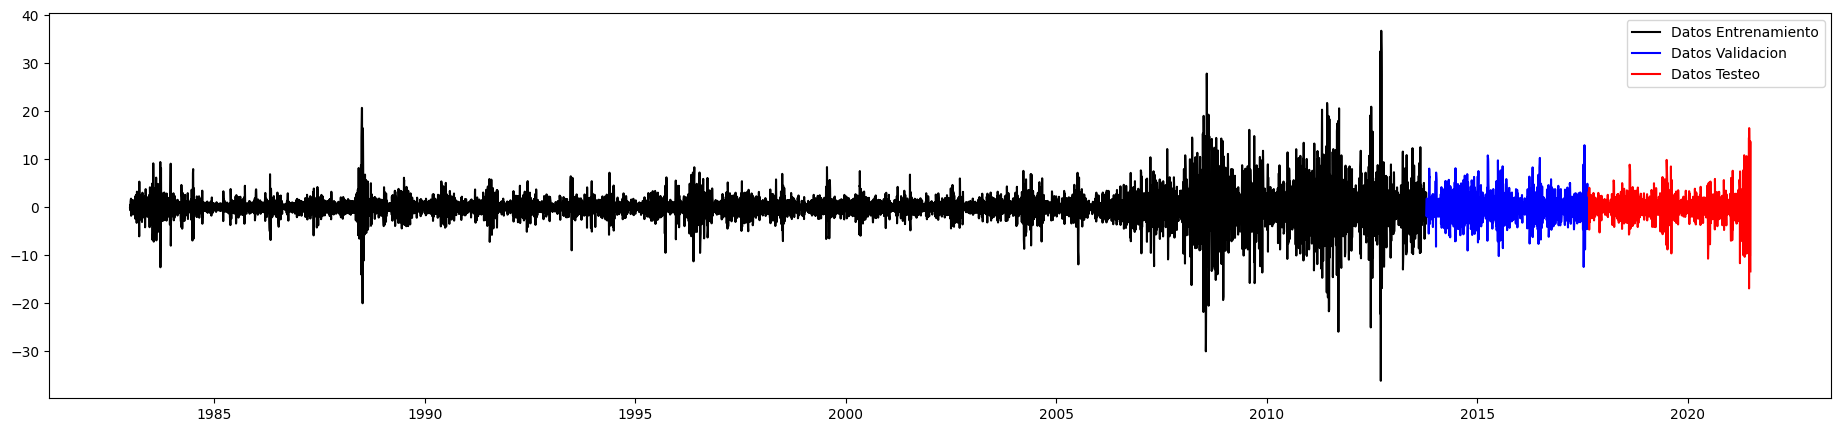

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

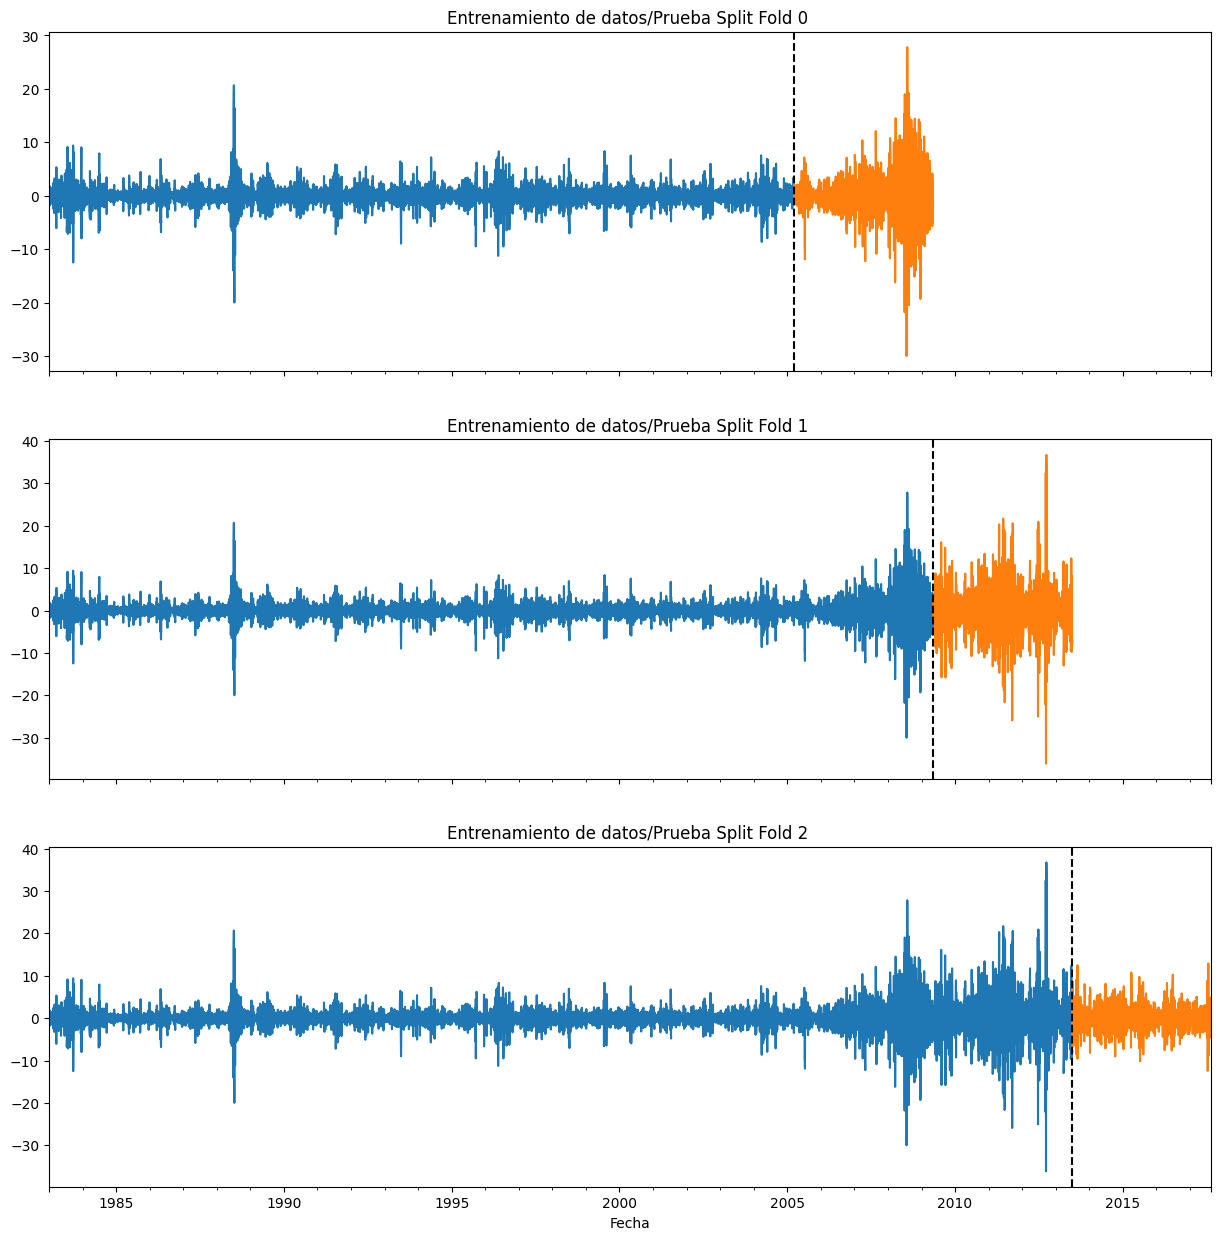

In [ ]:
#configurar el modelo dividido de series temporales
tss = TimeSeriesSplit(n_splits= 3 , test_size= 1515 , gap= 1 )


#ilustra cómo se entrenarán los datos con múltiples pliegues
fig, axs = plt.subplots( 3 , 1 , figsize=( 15 , 15 ), sharex= True )


fold = 0
for train_idx, val_idx in tss.split(modo_1[:division_validacion]):
    train = modo_1.iloc[train_idx]
    test = modo_1.iloc[val_idx]
    train[ 'Precio_Cierre' ].plot(ax=axs[fold],
                          label= 'Conjunto de entrenamiento' ,
                          title= f'Entrenamiento de datos/Prueba Split Fold {fold} ' )
    test[ 'Precio_Cierre' ].plot(ax=axs[fold],
                         label= 'Conjunto de prueba' )
    axs[fold].axvline(test.index. min (), color= 'black' , ls= '--' )
    fold += 1
plt.show()

Despues de una busqueda de hiperparametros se me brinda el mejor rendimiento con un learning rate de 0.2 y un max depth de 3 y subsample 0.9

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_1 = modo_1.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_1[:division_validacion]) :
    train = modo_1.iloc[train_idx]
    test = modo_1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 3 ,
                           learning_rate= 0.2,
                             subsample=0.9
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_1 = reg.predict(X_test)
    validacion_modo_1 = pd.Series(validacion_modo_1)
    preds.append(validacion_modo_1)
    score = np.sqrt(mean_squared_error(validacion_modo_1,y_test))
    mae = mean_absolute_error(validacion_modo_1,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_1,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]



#imprimir puntuaciones para cada pliegue
print ( f'raiz error cuadratico medio entre pliegues {np.mean(puntuaciones)} ' )
print ( f'error cuadratico medios pliegues: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:3.25968	validation_1-rmse:3.37590
[50]	validation_0-rmse:3.08117	validation_1-rmse:3.62007
[0]	validation_0-rmse:3.26399	validation_1-rmse:2.59445
[49]	validation_0-rmse:3.09974	validation_1-rmse:2.73250
[0]	validation_0-rmse:3.24459	validation_1-rmse:2.51874
[52]	validation_0-rmse:3.07650	validation_1-rmse:2.55475
raiz error cuadratico medio entre pliegues 2.829134528554994 
error cuadratico medios pliegues: [3.3758986192780767, 2.594445469240753, 2.517059497146153] 
Error Absoluto medio entre pliegues 2.1362157526752688
porcentaje de error absoluto medio entre pliegues 77.37900064453528


In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento[CARACTERISTICAS]
y_train =  datos_entrenamiento.Precio_Cierre

X_test = datos_validacion[CARACTERISTICAS]
y_test = datos_validacion.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            # Objective= 'reg:squarederror' ,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
      y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)
     # score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))
      score = mean_absolute_percentage_error(y_predict,datos_validacion.Precio_Cierre)

      errores.append((i,j,k,score))
    #errores_learning_rate.append(score)
    #errores_max_depth.append(score)

[0]	validation_0-rmse:3.27833	validation_1-rmse:2.83950
[49]	validation_0-rmse:3.26639	validation_1-rmse:2.84928
[0]	validation_0-rmse:3.27838	validation_1-rmse:2.83953
[49]	validation_0-rmse:3.26679	validation_1-rmse:2.84804
[0]	validation_0-rmse:3.27829	validation_1-rmse:2.83942
[49]	validation_0-rmse:3.26731	validation_1-rmse:2.84620
[0]	validation_0-rmse:3.27803	validation_1-rmse:2.83978
[49]	validation_0-rmse:3.25578	validation_1-rmse:2.86806
[0]	validation_0-rmse:3.27823	validation_1-rmse:2.83996
[49]	validation_0-rmse:3.25525	validation_1-rmse:2.87976
[0]	validation_0-rmse:3.27790	validation_1-rmse:2.83975
[50]	validation_0-rmse:3.25442	validation_1-rmse:2.88325
[0]	validation_0-rmse:3.27772	validation_1-rmse:2.84073
[49]	validation_0-rmse:3.24358	validation_1-rmse:2.88674
[0]	validation_0-rmse:3.27797	validation_1-rmse:2.83972
[50]	validation_0-rmse:3.24327	validation_1-rmse:2.91270
[0]	validation_0-rmse:3.27760	validation_1-rmse:2.84083
[49]	validation_0-rmse:3.24404	validatio

In [ ]:
#errores

In [ ]:
reg.fit(datos_entrenamiento[CARACTERISTICAS], datos_entrenamiento.Precio_Cierre,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

validacion_modo_1 = reg.predict(datos_validacion[CARACTERISTICAS])

[0]	validation_0-rmse:3.24320	validation_1-rmse:2.90917
[49]	validation_0-rmse:2.43691	validation_1-rmse:3.71701


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=modo_1[CARACTERISTICAS][:division_validacion]
y_train = modo_1[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_1 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_1))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:3.20826	validation_1-rmse:2.82867
[100]	validation_0-rmse:2.10559	validation_1-rmse:1.77980
[200]	validation_0-rmse:1.58055	validation_1-rmse:1.24525
[300]	validation_0-rmse:1.24410	validation_1-rmse:0.93038
[400]	validation_0-rmse:0.99494	validation_1-rmse:0.67888
[500]	validation_0-rmse:0.81000	validation_1-rmse:0.53386
[600]	validation_0-rmse:0.66908	validation_1-rmse:0.43364
[700]	validation_0-rmse:0.55637	validation_1-rmse:0.35517
[800]	validation_0-rmse:0.46136	validation_1-rmse:0.28173
[900]	validation_0-rmse:0.38679	validation_1-rmse:0.23667
[999]	validation_0-rmse:0.32849	validation_1-rmse:0.19405
El error Cuadratico medio del modelo es 3.3121312933736453


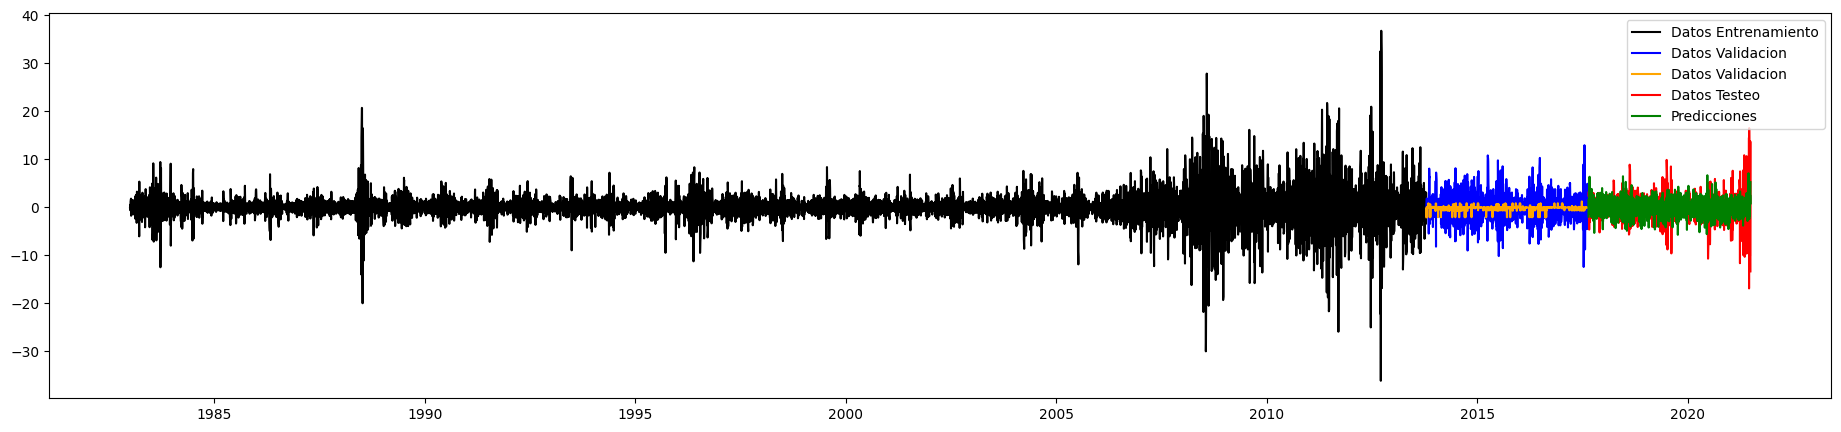

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion.index,validacion_modo_1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Modelaremos el segundo modo

In [ ]:
modo_2 = modo_2.asfreq('D')
modo_2.interpolate(inplace=True)

In [ ]:
modo_2 = create_features(modo_2)
modo_2 = add_lags(modo_2)
modo_2.dropna(inplace=True)
modo_2.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-3.325251,4,2,6,2021,176,25,25,-6.677701,0.735599,-0.212713
2021-06-26,-1.939724,5,2,6,2021,177,26,25,-5.211159,-2.101453,-0.227424
2021-06-27,-0.554196,6,2,6,2021,178,27,25,-3.805438,-5.383060,0.505661
2021-06-28,0.831332,0,2,6,2021,179,28,26,-2.399718,-6.304130,-0.153426
2021-06-29,1.119754,1,2,6,2021,180,29,26,-0.993997,-7.225200,-0.931906


In [ ]:
total_datos=len(modo_2.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_2[:division_entrenamiento]
datos_validacion = modo_2[division_entrenamiento:division_validacion]
datos_testeo = modo_2[division_validacion:total_datos]

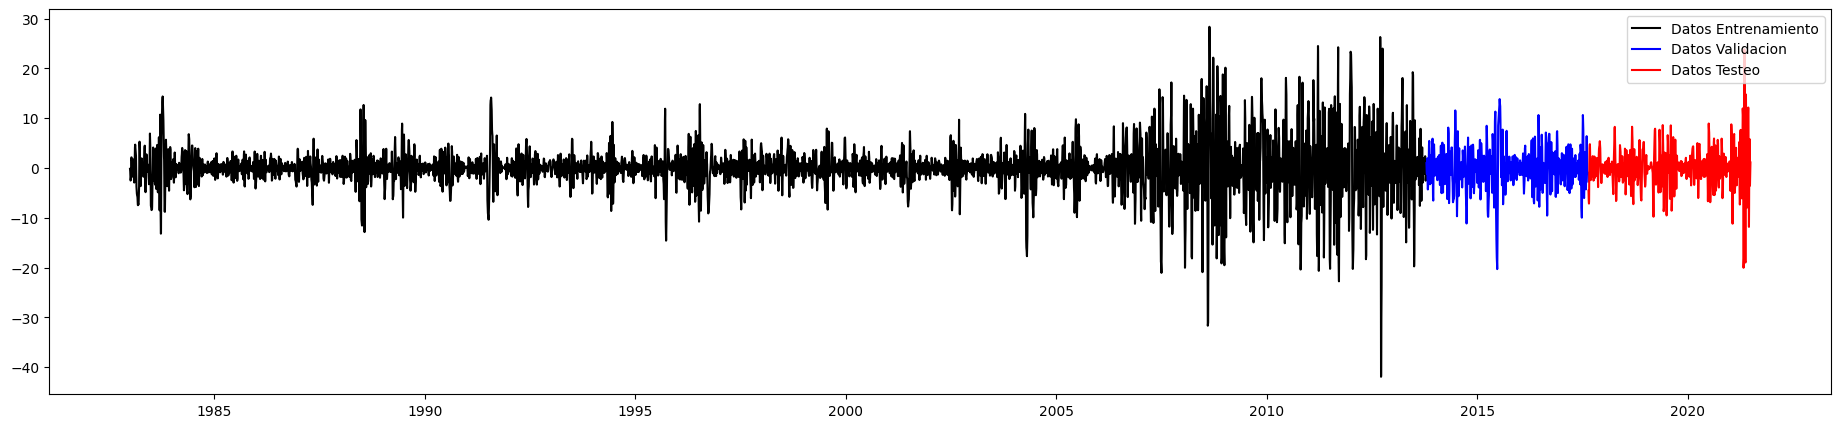

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento[CARACTERISTICAS]
y_train =  datos_entrenamiento.Precio_Cierre

X_test = datos_validacion[CARACTERISTICAS]
y_test = datos_validacion.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            # Objective= 'reg:squarederror' ,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
      y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      score = mean_absolute_percentage_error(y_predict,datos_validacion.Precio_Cierre)

      errores.append((i,j,k,score))

[0]	validation_0-rmse:4.58564	validation_1-rmse:4.12431
[100]	validation_0-rmse:4.54164	validation_1-rmse:4.12321
[120]	validation_0-rmse:4.53509	validation_1-rmse:4.12362
[0]	validation_0-rmse:4.58565	validation_1-rmse:4.12429
[100]	validation_0-rmse:4.54360	validation_1-rmse:4.12159
[197]	validation_0-rmse:4.51556	validation_1-rmse:4.12637
[0]	validation_0-rmse:4.58538	validation_1-rmse:4.12440
[100]	validation_0-rmse:4.54602	validation_1-rmse:4.11967
[200]	validation_0-rmse:4.51843	validation_1-rmse:4.12295
[212]	validation_0-rmse:4.51468	validation_1-rmse:4.12849
[0]	validation_0-rmse:4.58521	validation_1-rmse:4.12451
[100]	validation_0-rmse:4.49676	validation_1-rmse:4.12359
[117]	validation_0-rmse:4.48515	validation_1-rmse:4.12538
[0]	validation_0-rmse:4.58523	validation_1-rmse:4.12427
[100]	validation_0-rmse:4.50023	validation_1-rmse:4.11771
[141]	validation_0-rmse:4.47538	validation_1-rmse:4.12307
[0]	validation_0-rmse:4.58473	validation_1-rmse:4.12436
[100]	validation_0-rmse:4.

In [ ]:
errores

[(0.01, 2, 0.8, 241.36831948166392),
 (0.01, 2, 0.9, 95.17491517060537),
 (0.01, 2, 1.0, 342.7256723980837),
 (0.01, 3, 0.8, 190.20194054705468),
 (0.01, 3, 0.9, 131.10749795654212),
 (0.01, 3, 1.0, 126.61045907513339),
 (0.01, 4, 0.8, 163.98650389075107),
 (0.01, 4, 0.9, 694.3502880516216),
 (0.01, 4, 1.0, 324.8142710118221),
 (0.01, 5, 0.8, 214.12147183023725),
 (0.01, 5, 0.9, 518.3678378569408),
 (0.01, 5, 1.0, 414.5866644393214),
 (0.01, 6, 0.8, 168.99068331130576),
 (0.01, 6, 0.9, 232.03511947172916),
 (0.01, 6, 1.0, 229.40332238629216),
 (0.1, 2, 0.8, 67.09574197493357),
 (0.1, 2, 0.9, 84.66906943279218),
 (0.1, 2, 1.0, 61.456605045252815),
 (0.1, 3, 0.8, 32.90471024996286),
 (0.1, 3, 0.9, 32.46155087951762),
 (0.1, 3, 1.0, 72.83330436144807),
 (0.1, 4, 0.8, 105.05948801519543),
 (0.1, 4, 0.9, 159.0542980345995),
 (0.1, 4, 1.0, 25.812959505633913),
 (0.1, 5, 0.8, 81.64417579347338),
 (0.1, 5, 0.9, 111.47024571245504),
 (0.1, 5, 1.0, 3821.787587607149),
 (0.1, 6, 0.8, 61.203219716

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_2 = modo_2.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_2[:division_validacion]) :
    train = modo_2.iloc[train_idx]
    test = modo_2.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.2,
                            subsample=1.0)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_2 = reg.predict(X_test)
    validacion_modo_2 = pd.Series(validacion_modo_2)
    preds.append(validacion_modo_2)
    score = np.sqrt(mean_squared_error(validacion_modo_2,y_test))
    mae = mean_absolute_error(validacion_modo_2,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_2,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

validacion_modo_2 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:4.48215	validation_1-rmse:5.82368
[49]	validation_0-rmse:3.09471	validation_1-rmse:7.10926
[0]	validation_0-rmse:4.54073	validation_1-rmse:3.12793
[50]	validation_0-rmse:3.07282	validation_1-rmse:3.79090
[0]	validation_0-rmse:4.50845	validation_1-rmse:3.42432
[50]	validation_0-rmse:3.04326	validation_1-rmse:4.17641
Puntuación entre pliegues 4.125308574072275 
Puntuaciones plegar: [5.823675416029372, 3.1279271505409225, 3.42432315564653] 
Error Absoluto medio entre pliegues 3.010541291908003
porcentaje de error absoluto medio entre pliegues 39.632156588380326


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=modo_2[CARACTERISTICAS][:division_validacion]
y_train = modo_2[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_2 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_2))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:4.46823	validation_1-rmse:3.40865
[100]	validation_0-rmse:2.48154	validation_1-rmse:1.71880
[200]	validation_0-rmse:1.74885	validation_1-rmse:1.13172
[300]	validation_0-rmse:1.32801	validation_1-rmse:0.73550
[400]	validation_0-rmse:1.01611	validation_1-rmse:0.57356
[500]	validation_0-rmse:0.82548	validation_1-rmse:0.45775
[600]	validation_0-rmse:0.66963	validation_1-rmse:0.36128
[700]	validation_0-rmse:0.54390	validation_1-rmse:0.27126
[800]	validation_0-rmse:0.45177	validation_1-rmse:0.20992
[900]	validation_0-rmse:0.37322	validation_1-rmse:0.17135
[999]	validation_0-rmse:0.30734	validation_1-rmse:0.13635
El error Cuadratico medio del modelo es 4.685325002936277


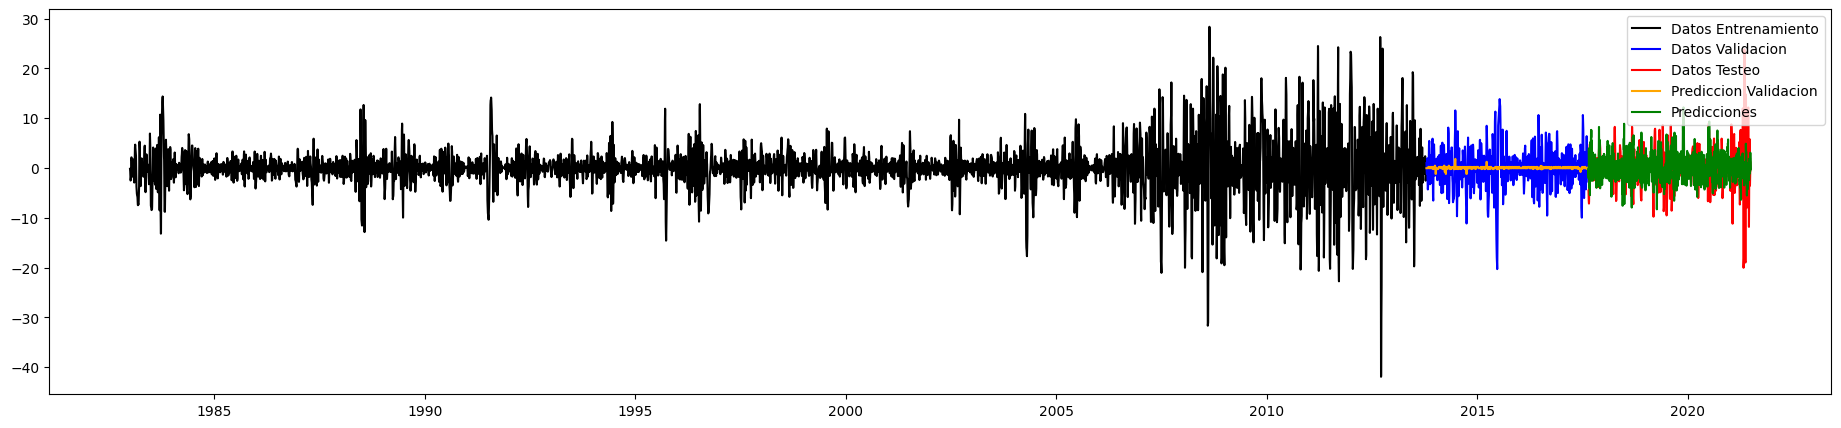

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion_modo_2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Modelaremos el 3 modo

In [ ]:
modo_3 = modo_3.asfreq('D')
modo_3.interpolate(inplace=True)

In [ ]:
modo_3 = create_features(modo_3)
modo_3 = add_lags(modo_3)
modo_3.dropna(inplace=True)
modo_3.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-32.789600,4,2,6,2021,176,25,25,-3.592603,-3.996361,-17.905550
2021-06-26,-32.945372,5,2,6,2021,177,26,25,-2.350497,-5.414302,-17.985613
2021-06-27,-33.101145,6,2,6,2021,178,27,25,-1.852694,-6.455362,-18.031209
2021-06-28,-33.256918,0,2,6,2021,179,28,26,-1.354891,-6.630746,-18.016305
2021-06-29,-32.983054,1,2,6,2021,180,29,26,-0.857087,-6.806130,-18.007256


In [ ]:
total_datos=len(modo_3.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_3[:division_entrenamiento]
datos_validacion = modo_3[division_entrenamiento:division_validacion]
datos_testeo = modo_3[division_validacion:total_datos]

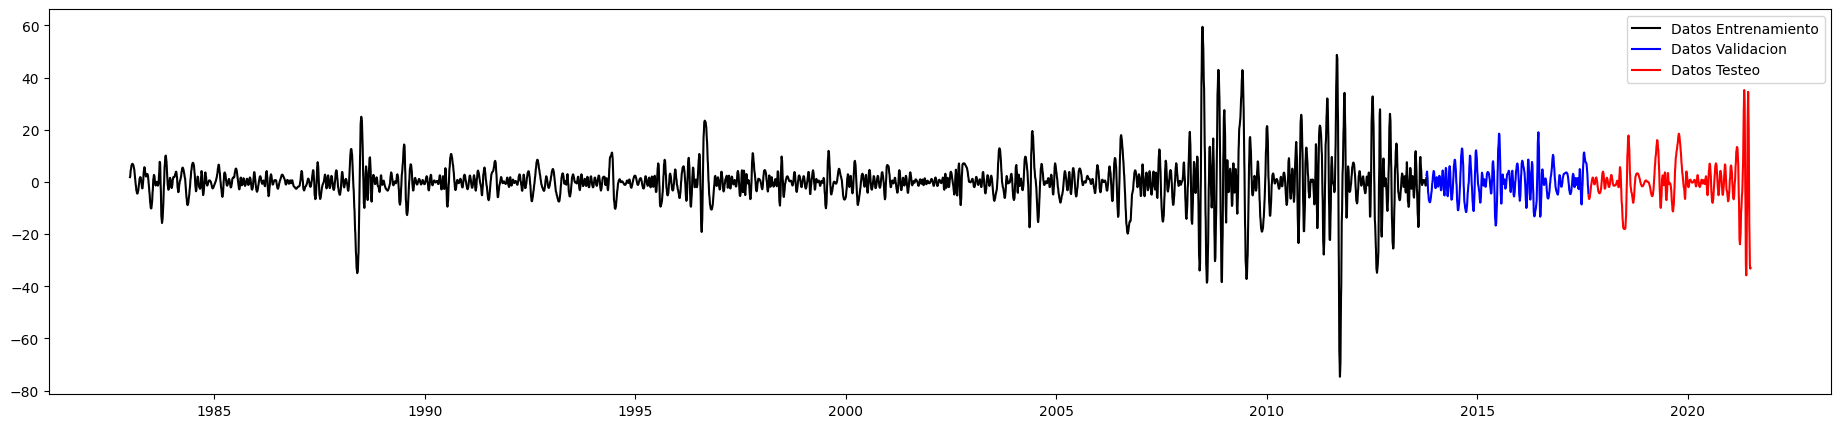

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Se hizo es una busque da hiperparametros y se encontro que los mejores hiperparametros son max depth 5 y learning rate 0.1

In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento[CARACTERISTICAS]
y_train =  datos_entrenamiento.Precio_Cierre

X_test = datos_validacion[CARACTERISTICAS]
y_test = datos_validacion.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
      y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      score = mean_absolute_percentage_error(y_predict,datos_validacion.Precio_Cierre)

      errores.append((i,j,k,score))

[0]	validation_0-rmse:8.37488	validation_1-rmse:5.88649
[50]	validation_0-rmse:8.30840	validation_1-rmse:6.13168
[0]	validation_0-rmse:8.37494	validation_1-rmse:5.88593
[50]	validation_0-rmse:8.30804	validation_1-rmse:6.10220
[0]	validation_0-rmse:8.37484	validation_1-rmse:5.87470
[52]	validation_0-rmse:8.31351	validation_1-rmse:6.15925
[0]	validation_0-rmse:8.37302	validation_1-rmse:5.88792
[49]	validation_0-rmse:8.21812	validation_1-rmse:6.28063
[0]	validation_0-rmse:8.37317	validation_1-rmse:5.88741
[50]	validation_0-rmse:8.20904	validation_1-rmse:6.31251
[0]	validation_0-rmse:8.37205	validation_1-rmse:5.88048
[49]	validation_0-rmse:8.23941	validation_1-rmse:6.27589
[0]	validation_0-rmse:8.36902	validation_1-rmse:5.89025
[49]	validation_0-rmse:8.09199	validation_1-rmse:6.43242
[0]	validation_0-rmse:8.36898	validation_1-rmse:5.88977
[49]	validation_0-rmse:8.08579	validation_1-rmse:6.52955
[0]	validation_0-rmse:8.36939	validation_1-rmse:5.88701
[50]	validation_0-rmse:8.09135	validatio

In [ ]:
errores

[(0.01, 2, 0.8, 86.49444035253731),
 (0.01, 2, 0.9, 97.70384774468685),
 (0.01, 2, 1.0, 74.21401359007675),
 (0.01, 3, 0.8, 80.97414139184312),
 (0.01, 3, 0.9, 81.64496214972624),
 (0.01, 3, 1.0, 79.86249755430559),
 (0.01, 4, 0.8, 93.33653918974271),
 (0.01, 4, 0.9, 94.29051785593857),
 (0.01, 4, 1.0, 3075.4447272575567),
 (0.01, 5, 0.8, 113.75761507705094),
 (0.01, 5, 0.9, 88.00106319320653),
 (0.01, 5, 1.0, 68.92006632406463),
 (0.01, 6, 0.8, 107.09984327901755),
 (0.01, 6, 0.9, 101.73867501347813),
 (0.01, 6, 1.0, 81.80943368517737),
 (0.01, 7, 0.8, 103.54813525576253),
 (0.01, 7, 0.9, 92.82715850019169),
 (0.01, 7, 1.0, 73.28246131697055),
 (0.01, 8, 0.8, 89.56501902195208),
 (0.01, 8, 0.9, 93.4210017927024),
 (0.01, 8, 1.0, 301.67971971462714),
 (0.1, 2, 0.8, 60.4588112765064),
 (0.1, 2, 0.9, 60.057383120076715),
 (0.1, 2, 1.0, 76.96592767698903),
 (0.1, 3, 0.8, 161.0007695885551),
 (0.1, 3, 0.9, 114.30900742236938),
 (0.1, 3, 1.0, 84.35999180492655),
 (0.1, 4, 0.8, 96.1431825532

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_3 = modo_3.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_3[:division_validacion]) :
    train = modo_3.iloc[train_idx]
    test = modo_3.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                          # Objective= 'reg:squarederror' ,
                           max_depth= 6 ,
                           learning_rate= 0.2,
                            subsample=1.0)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_3 = reg.predict(X_test)
    validacion_modo_3 = pd.Series(validacion_modo_3)
    preds.append(validacion_modo_3)
    score = np.sqrt(mean_squared_error(validacion_modo_3,y_test))
    mae = mean_absolute_error(validacion_modo_3,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_3,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_3 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:8.02953	validation_1-rmse:7.95332
[49]	validation_0-rmse:3.60757	validation_1-rmse:10.63716
[0]	validation_0-rmse:8.01817	validation_1-rmse:6.22943
[51]	validation_0-rmse:3.61796	validation_1-rmse:6.92341
[0]	validation_0-rmse:7.96723	validation_1-rmse:4.61967
[49]	validation_0-rmse:3.76787	validation_1-rmse:6.05432
Puntuación entre pliegues 6.209821686458511 
Puntuaciones plegar: [7.95331639319916, 6.056474725138815, 4.619673941037558] 
Error Absoluto medio entre pliegues 4.9067724012139164
porcentaje de error absoluto medio entre pliegues 51.0474938646266


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=modo_3[CARACTERISTICAS][:division_validacion]
y_train = modo_3[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_3 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_3))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:7.89205	validation_1-rmse:4.51502
[100]	validation_0-rmse:2.60477	validation_1-rmse:1.54130
[200]	validation_0-rmse:1.53535	validation_1-rmse:0.83871
[300]	validation_0-rmse:1.05594	validation_1-rmse:0.60243
[400]	validation_0-rmse:0.78663	validation_1-rmse:0.44137
[500]	validation_0-rmse:0.60736	validation_1-rmse:0.35594
[600]	validation_0-rmse:0.47867	validation_1-rmse:0.26315
[700]	validation_0-rmse:0.38033	validation_1-rmse:0.20649
[800]	validation_0-rmse:0.31078	validation_1-rmse:0.17832
[900]	validation_0-rmse:0.25516	validation_1-rmse:0.14533
[999]	validation_0-rmse:0.21347	validation_1-rmse:0.11901
El error Cuadratico medio del modelo es 9.478201660559089


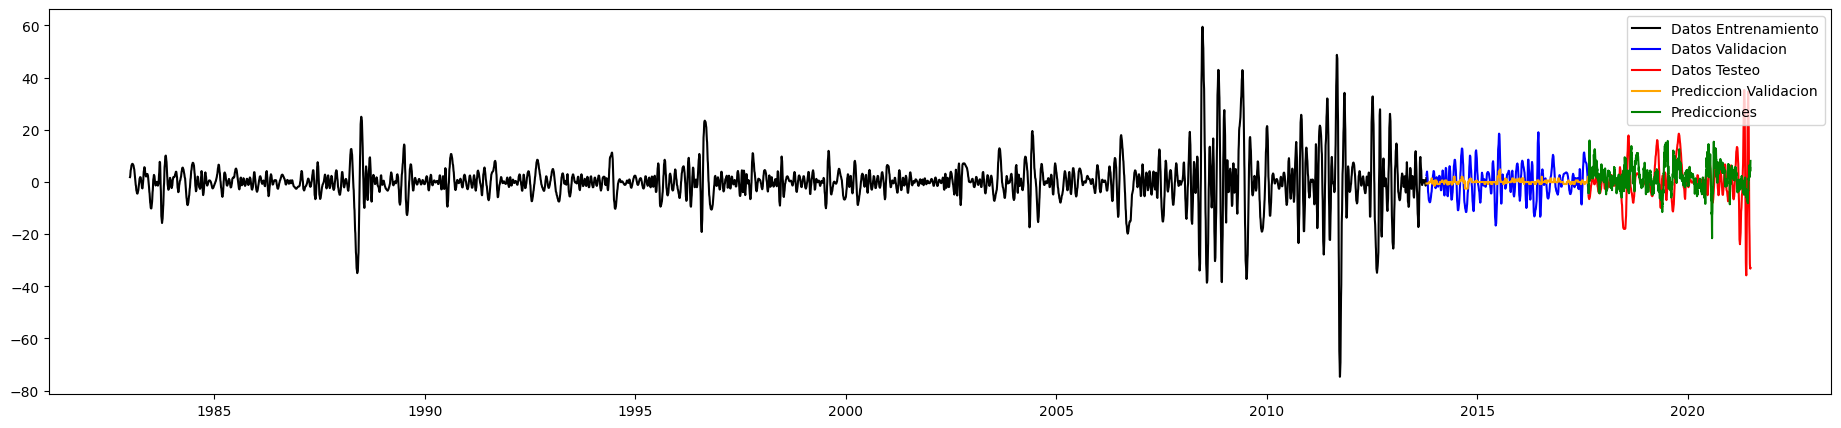

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion_modo_3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,prediccion_modo_3,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# modelaremos el modo 4

In [ ]:
modo_4 = modo_4.asfreq('D')
modo_4.interpolate(inplace=True)

In [ ]:
modo_4 = create_features(modo_4)
modo_4 = add_lags(modo_4)
modo_4.dropna(inplace=True)
modo_4.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,-12.558170,4,2,6,2021,176,25,25,6.885688,22.919694,-6.978189
2021-06-26,-12.877660,5,2,6,2021,177,26,25,6.361690,22.428777,-7.811410
2021-06-27,-13.197150,6,2,6,2021,178,27,25,6.175303,21.953860,-8.616554
2021-06-28,-13.516641,0,2,6,2021,179,28,26,5.988915,21.808715,-9.389372
2021-06-29,-14.455109,1,2,6,2021,180,29,26,5.802528,21.663571,-9.634787


In [ ]:
total_datos=len(modo_4.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_4[:division_entrenamiento]
datos_validacion = modo_4[division_entrenamiento:division_validacion]
datos_testeo = modo_4[division_validacion:total_datos]

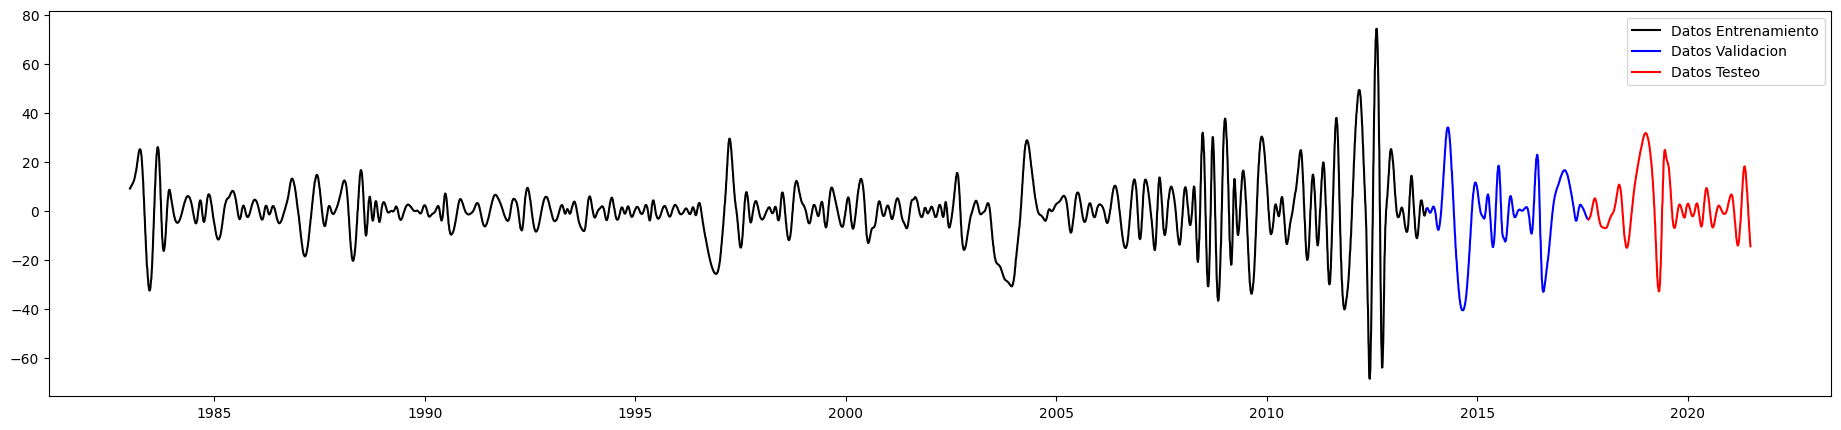

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento[CARACTERISTICAS]
y_train =  datos_entrenamiento.Precio_Cierre

X_test = datos_validacion[CARACTERISTICAS]
y_test = datos_validacion.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
      y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      score = mean_absolute_percentage_error(y_predict,datos_validacion.Precio_Cierre)
      #score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))

      errores.append((i,j,k,score))

[0]	validation_0-rmse:12.25204	validation_1-rmse:14.96392
[49]	validation_0-rmse:11.85598	validation_1-rmse:15.90841
[0]	validation_0-rmse:12.25255	validation_1-rmse:14.96313
[49]	validation_0-rmse:11.85858	validation_1-rmse:15.90220
[0]	validation_0-rmse:12.25257	validation_1-rmse:14.96020
[49]	validation_0-rmse:11.85622	validation_1-rmse:15.83702
[0]	validation_0-rmse:12.23909	validation_1-rmse:14.96946
[49]	validation_0-rmse:11.41506	validation_1-rmse:17.02916
[0]	validation_0-rmse:12.23959	validation_1-rmse:14.96866
[50]	validation_0-rmse:11.38706	validation_1-rmse:17.22226
[0]	validation_0-rmse:12.23926	validation_1-rmse:14.96882
[50]	validation_0-rmse:11.37042	validation_1-rmse:17.38896
[0]	validation_0-rmse:12.23054	validation_1-rmse:14.96116
[49]	validation_0-rmse:11.04046	validation_1-rmse:17.61466
[0]	validation_0-rmse:12.23059	validation_1-rmse:14.96062
[50]	validation_0-rmse:11.02758	validation_1-rmse:17.63936
[0]	validation_0-rmse:12.22961	validation_1-rmse:14.97238
[50]	v

In [ ]:
errores

[(0.01, 2, 0.8, 91.78581843975768),
 (0.01, 2, 0.9, 86.24907255973842),
 (0.01, 2, 1.0, 69.55712331824822),
 (0.01, 3, 0.8, 57.16927760432525),
 (0.01, 3, 0.9, 56.217883036667),
 (0.01, 3, 1.0, 56.96106241254702),
 (0.01, 4, 0.8, 56.6197528687503),
 (0.01, 4, 0.9, 55.33829418161019),
 (0.01, 4, 1.0, 61.69874207704751),
 (0.01, 5, 0.8, 337.28433281119857),
 (0.01, 5, 0.9, 82.64374713370404),
 (0.01, 5, 1.0, 107.33027914700271),
 (0.01, 6, 0.8, 61.53434004350378),
 (0.01, 6, 0.9, 115.44351697255676),
 (0.01, 6, 1.0, 94.72415296858),
 (0.01, 7, 0.8, 8497.423911009151),
 (0.01, 7, 0.9, 1350.693384517104),
 (0.01, 7, 1.0, 53.126027315239476),
 (0.01, 8, 0.8, 68.01281162130881),
 (0.01, 8, 0.9, 53.372831204561024),
 (0.01, 8, 1.0, 55.75727488661319),
 (0.1, 2, 0.8, 16.975288411963838),
 (0.1, 2, 0.9, 17.47953237707408),
 (0.1, 2, 1.0, 22.47109208410287),
 (0.1, 3, 0.8, 28.8996566190245),
 (0.1, 3, 0.9, 34.188088438361326),
 (0.1, 3, 1.0, 29.579820112147463),
 (0.1, 4, 0.8, 19.574070095548603

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_4 = modo_4.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_4[:division_validacion]) :
    train = modo_4.iloc[train_idx]
    test = modo_4.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           #Objective= 'reg:squarederror' ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_4 = reg.predict(X_test)
    validacion_modo_4 = pd.Series(validacion_modo_4)
    preds.append(validacion_modo_4)
    score = np.sqrt(mean_squared_error(validacion_modo_4,y_test))
    mae = mean_absolute_error(validacion_modo_4,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_4,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_4 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:12.46525	validation_1-rmse:16.10767
[50]	validation_0-rmse:10.27262	validation_1-rmse:19.26316
[0]	validation_0-rmse:12.58813	validation_1-rmse:12.82553
[100]	validation_0-rmse:8.97375	validation_1-rmse:12.20113
[114]	validation_0-rmse:8.64645	validation_1-rmse:12.19283
[0]	validation_0-rmse:12.59692	validation_1-rmse:10.23236
[74]	validation_0-rmse:9.71350	validation_1-rmse:9.55459
Puntuación entre pliegues 12.39229532555583 
Puntuaciones plegar: [16.10767146621647, 11.960396639776514, 9.108817870674509] 
Error Absoluto medio entre pliegues 9.535815791048813
porcentaje de error absoluto medio entre pliegues 29.514385385228184


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=modo_4[CARACTERISTICAS][:division_validacion]
y_train = modo_4[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_4 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_4))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:12.54127	validation_1-rmse:10.21657
[100]	validation_0-rmse:9.26323	validation_1-rmse:6.59247
[200]	validation_0-rmse:7.48599	validation_1-rmse:4.43866
[300]	validation_0-rmse:6.53159	validation_1-rmse:3.29025
[400]	validation_0-rmse:5.85718	validation_1-rmse:2.63755
[500]	validation_0-rmse:5.31135	validation_1-rmse:2.21315
[600]	validation_0-rmse:4.87319	validation_1-rmse:1.92962
[700]	validation_0-rmse:4.45022	validation_1-rmse:1.75497
[800]	validation_0-rmse:4.02355	validation_1-rmse:1.59221
[900]	validation_0-rmse:3.67034	validation_1-rmse:1.47745
[999]	validation_0-rmse:3.37636	validation_1-rmse:1.31986
El error Cuadratico medio del modelo es 11.3332956646803


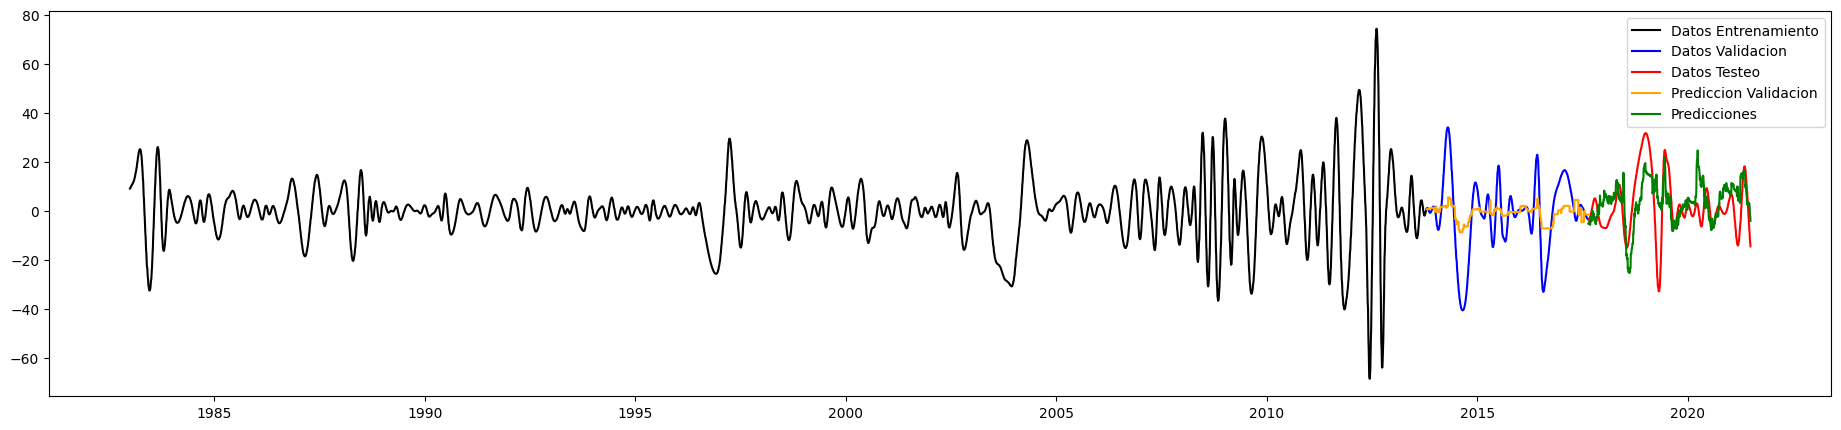

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion_modo_4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,prediccion_modo_4,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# modelaremos el modo 5

In [ ]:
modo_5 = modo_5.asfreq('D')
modo_5.interpolate(inplace=True)

In [ ]:
modo_5 = create_features(modo_5)
modo_5 = add_lags(modo_5)
modo_5.dropna(inplace=True)
modo_5.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,14.393662,4,2,6,2021,176,25,25,-4.026809,22.632876,22.313580
2021-06-26,14.402947,5,2,6,2021,177,26,25,-3.838563,22.384339,22.015921
2021-06-27,14.412232,6,2,6,2021,178,27,25,-3.775253,22.107648,21.708921
2021-06-28,14.421516,0,2,6,2021,179,28,26,-3.711943,22.006301,21.392713
2021-06-29,14.440185,1,2,6,2021,180,29,26,-3.648633,21.904955,21.284287


In [ ]:
total_datos=len(modo_4.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_5[:division_entrenamiento]
datos_validacion = modo_5[division_entrenamiento:division_validacion]
datos_testeo = modo_5[division_validacion:total_datos]

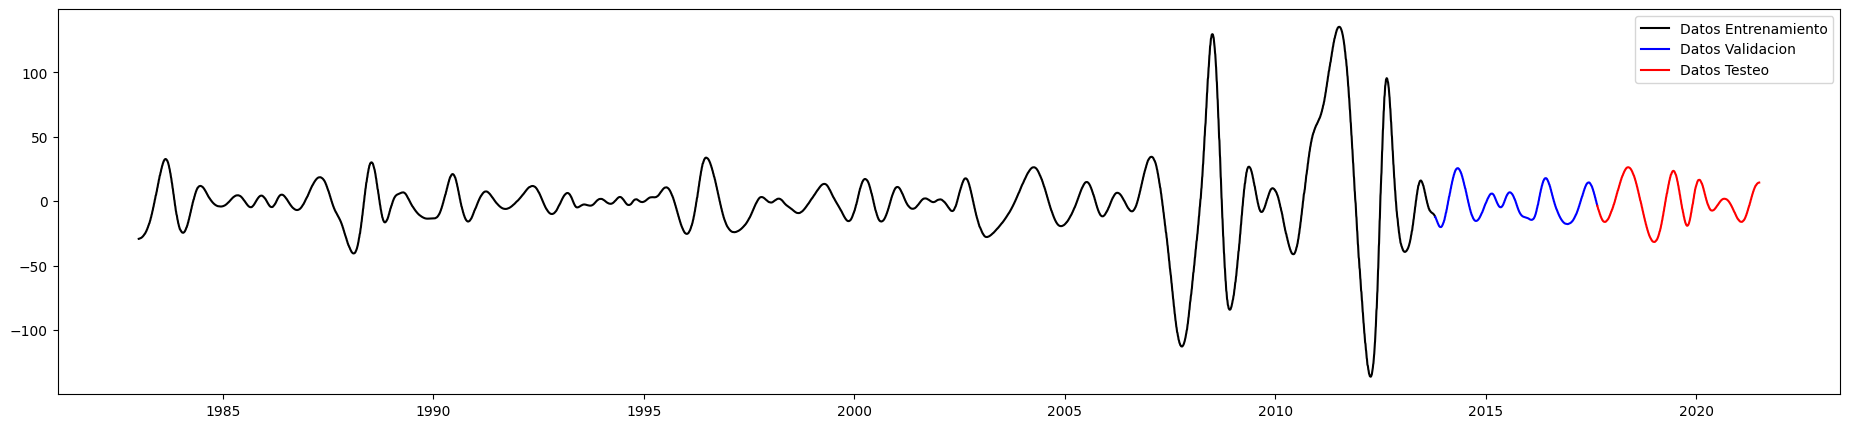

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_5 = modo_5.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_5[:division_validacion]) :
    train = modo_5.iloc[train_idx]
    test = modo_5.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.2,
                            subsample=0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_5 = reg.predict(X_test)
    validacion_modo_5 = pd.Series(validacion_modo_5)
    preds.append( validacion_modo_5)
    score = np.sqrt(mean_squared_error( validacion_modo_5,y_test))
    mae = mean_absolute_error( validacion_modo_5,y_test)
    mape = mean_absolute_percentage_error( validacion_modo_5,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_5 = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:27.59713	validation_1-rmse:11.42296
[49]	validation_0-rmse:2.28520	validation_1-rmse:23.95936
[0]	validation_0-rmse:27.20626	validation_1-rmse:10.00585
[51]	validation_0-rmse:2.24827	validation_1-rmse:13.06829
[0]	validation_0-rmse:26.94591	validation_1-rmse:12.01524
[100]	validation_0-rmse:1.22450	validation_1-rmse:8.79848
[200]	validation_0-rmse:0.66490	validation_1-rmse:8.76234
[210]	validation_0-rmse:0.63589	validation_1-rmse:8.77747
Puntuación entre pliegues 9.852709557583566 
Puntuaciones plegar: [11.422962750038673, 9.409175376284928, 8.725990546427097] 
Error Absoluto medio entre pliegues 7.808254959211481
porcentaje de error absoluto medio entre pliegues 3.3951685008696812


In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento[CARACTERISTICAS]
y_train =  datos_entrenamiento.Precio_Cierre

X_test = datos_validacion[CARACTERISTICAS]
y_test = datos_validacion.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            # Objective= 'reg:squarederror' ,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
      y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      score = mean_absolute_percentage_error(y_predict,datos_validacion.Precio_Cierre)

      errores.append((i,j,k,score))

[0]	validation_0-rmse:32.26191	validation_1-rmse:11.87510
[51]	validation_0-rmse:30.05986	validation_1-rmse:30.20564
[0]	validation_0-rmse:32.26132	validation_1-rmse:11.87408
[51]	validation_0-rmse:30.06052	validation_1-rmse:30.15184
[0]	validation_0-rmse:32.26104	validation_1-rmse:11.87346
[50]	validation_0-rmse:30.08999	validation_1-rmse:29.66315
[0]	validation_0-rmse:32.21154	validation_1-rmse:11.92812
[50]	validation_0-rmse:28.64942	validation_1-rmse:30.91943
[0]	validation_0-rmse:32.21108	validation_1-rmse:11.92644
[50]	validation_0-rmse:28.61492	validation_1-rmse:31.01385
[0]	validation_0-rmse:32.21016	validation_1-rmse:11.91219
[49]	validation_0-rmse:28.65956	validation_1-rmse:30.56708
[0]	validation_0-rmse:32.17293	validation_1-rmse:11.94055
[50]	validation_0-rmse:26.90173	validation_1-rmse:31.83956
[0]	validation_0-rmse:32.17253	validation_1-rmse:11.93880
[50]	validation_0-rmse:26.79662	validation_1-rmse:32.20595
[0]	validation_0-rmse:32.17232	validation_1-rmse:11.93744
[50]	v

In [ ]:
errores

[(0.01, 2, 0.8, 7.86470117588583),
 (0.01, 2, 0.9, 7.794689642360506),
 (0.01, 2, 1.0, 7.769372531533048),
 (0.01, 3, 0.8, 16.389443474548923),
 (0.01, 3, 0.9, 16.092957607907202),
 (0.01, 3, 1.0, 15.83892147414978),
 (0.01, 4, 0.8, 31.649480911667045),
 (0.01, 4, 0.9, 29.569548876727616),
 (0.01, 4, 1.0, 17.713486892785028),
 (0.01, 5, 0.8, 84.16087762542452),
 (0.01, 5, 0.9, 87.73583211585445),
 (0.01, 5, 1.0, 49.979894642433415),
 (0.01, 6, 0.8, 27.707445794801433),
 (0.01, 6, 0.9, 27.352531793603582),
 (0.01, 6, 1.0, 41.77537772073874),
 (0.1, 2, 0.8, 2.7303337614905523),
 (0.1, 2, 0.9, 2.6531033122384198),
 (0.1, 2, 1.0, 2.606249614360599),
 (0.1, 3, 0.8, 3.39746352193206),
 (0.1, 3, 0.9, 3.6459869335041906),
 (0.1, 3, 1.0, 4.456764821925588),
 (0.1, 4, 0.8, 1.9775909141348031),
 (0.1, 4, 0.9, 1.9827670472858225),
 (0.1, 4, 1.0, 2.533675405500064),
 (0.1, 5, 0.8, 2.075489661015275),
 (0.1, 5, 0.9, 2.0523478955791403),
 (0.1, 5, 1.0, 2.9753570915081866),
 (0.1, 6, 0.8, 2.1089573591

In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=modo_5[CARACTERISTICAS][:division_validacion]
y_train = modo_5[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_5 = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_modo_5))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:26.82463	validation_1-rmse:10.71470
[100]	validation_0-rmse:1.35838	validation_1-rmse:0.93209
[200]	validation_0-rmse:0.71912	validation_1-rmse:0.54779
[300]	validation_0-rmse:0.49475	validation_1-rmse:0.38398
[400]	validation_0-rmse:0.38197	validation_1-rmse:0.30002
[500]	validation_0-rmse:0.30196	validation_1-rmse:0.23222
[600]	validation_0-rmse:0.24595	validation_1-rmse:0.18575
[700]	validation_0-rmse:0.20442	validation_1-rmse:0.15222
[800]	validation_0-rmse:0.17180	validation_1-rmse:0.12599
[900]	validation_0-rmse:0.14618	validation_1-rmse:0.10683
[999]	validation_0-rmse:0.12513	validation_1-rmse:0.08979
El error Cuadratico medio del modelo es 13.003176119981317


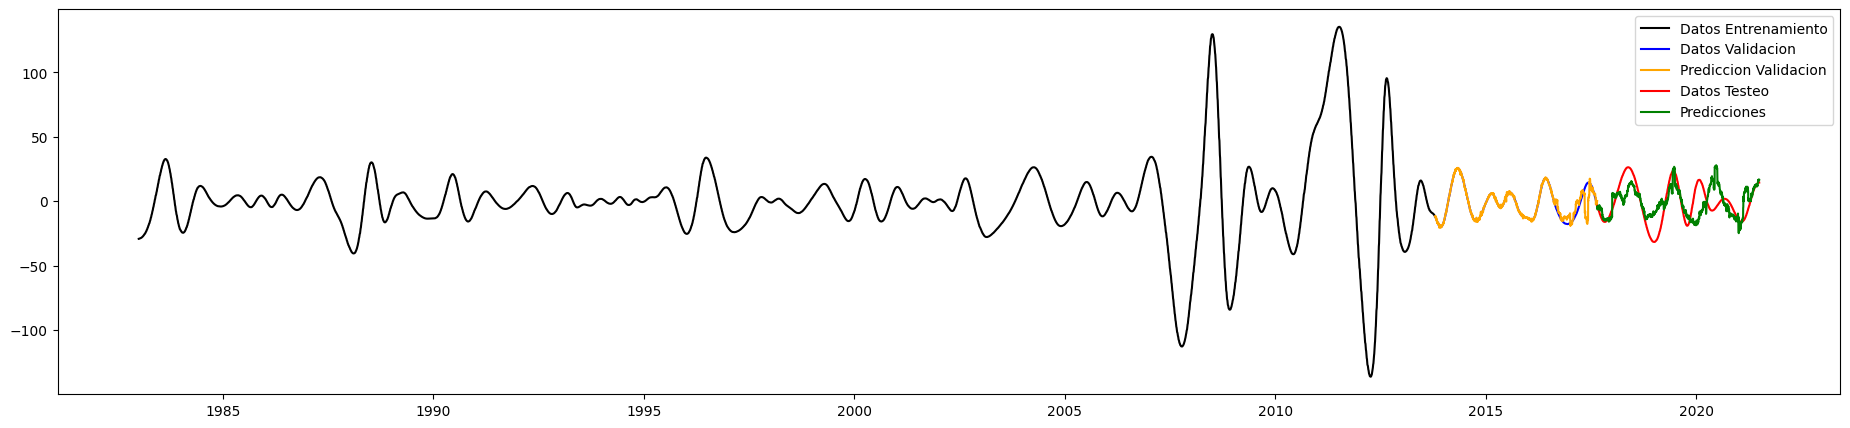

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion.index,validacion_modo_5,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,prediccion_modo_5,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Modelaremos el residuo

In [ ]:
residuo = residuo.asfreq('D')
residuo.interpolate(inplace=True)

In [ ]:
residuo = create_features(residuo)
residuo = add_lags(residuo)
residuo.dropna(inplace=True)
residuo.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,574.435915,4,2,6,2021,176,25,25,358.377596,414.924399,390.323020
2021-06-26,574.734706,5,2,6,2021,177,26,25,358.490814,414.928237,390.321375
2021-06-27,575.033497,6,2,6,2021,178,27,25,358.531167,414.928771,390.320717
2021-06-28,575.332288,0,2,6,2021,179,28,26,358.571520,414.927845,390.321049
2021-06-29,576.221887,1,2,6,2021,180,29,26,358.611874,414.926920,390.321490


In [ ]:
total_datos=len(residuo.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = residuo[:division_entrenamiento]
datos_validacion = residuo[division_entrenamiento:division_validacion]
datos_testeo = residuo[division_validacion:total_datos]

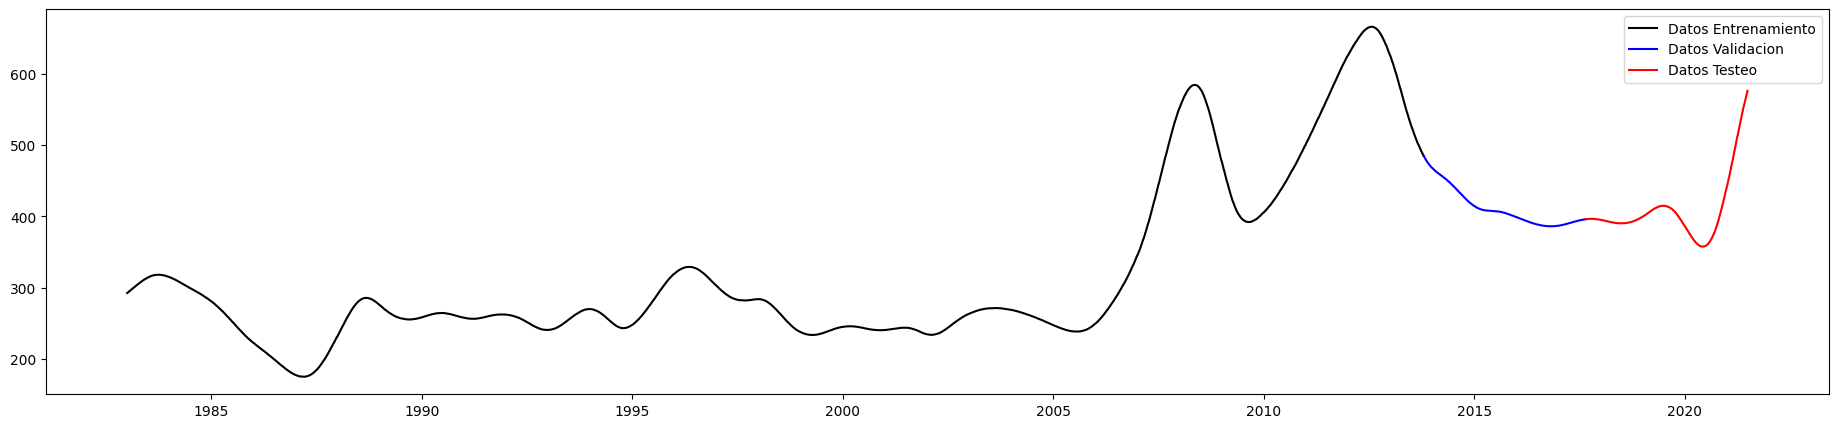

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
residuo = residuo.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(residuo[:division_validacion]) :
    train = residuo.iloc[train_idx]
    test = residuo.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 4 ,
                           learning_rate= 0.1,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_residuo = reg.predict(X_test)
    validacion_residuo = pd.Series(validacion_residuo)
    preds.append(validacion_residuo)
    score = np.sqrt(mean_squared_error(validacion_residuo,y_test))
    mae = mean_absolute_error(validacion_residuo,y_test)
    mape = mean_absolute_percentage_error(validacion_residuo,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_residuo = reg.predict(datos_validacion[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:106.85159	validation_1-rmse:77.97755
[57]	validation_0-rmse:5.87925	validation_1-rmse:66.34445
[0]	validation_0-rmse:106.25693	validation_1-rmse:51.60447
[53]	validation_0-rmse:7.14630	validation_1-rmse:129.43170
[0]	validation_0-rmse:105.31885	validation_1-rmse:57.19379
[68]	validation_0-rmse:5.30109	validation_1-rmse:25.35120
Puntuación entre pliegues 11.449447527253474 
Puntuaciones plegar: [24.862878056091883, 6.04002801814112, 3.4454365075274183] 
Error Absoluto medio entre pliegues 9.968042962268784
porcentaje de error absoluto medio entre pliegues 0.024300797514362506


In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [3, 4, 5]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento[CARACTERISTICAS]
y_train =  datos_entrenamiento.Precio_Cierre

X_test = datos_validacion[CARACTERISTICAS]
y_test = datos_validacion.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            # Objective= 'reg:squarederror' ,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)
      y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))
      #score = mean_absolute_percentage_error(y_predict,datos_validacion.Precio_Cierre)

      errores.append((i,j,k,score))
    #errores_learning_rate.append(score)
    #errores_max_depth.append(score)

[0]	validation_0-rmse:116.45819	validation_1-rmse:96.86479
[95]	validation_0-rmse:50.42656	validation_1-rmse:63.13651
[0]	validation_0-rmse:116.45954	validation_1-rmse:96.86693
[96]	validation_0-rmse:50.02011	validation_1-rmse:64.41675
[0]	validation_0-rmse:116.45942	validation_1-rmse:96.87159
[95]	validation_0-rmse:50.41194	validation_1-rmse:63.45939
[0]	validation_0-rmse:116.43740	validation_1-rmse:97.12865
[100]	validation_0-rmse:46.00893	validation_1-rmse:55.40071
[103]	validation_0-rmse:44.82431	validation_1-rmse:57.33661
[0]	validation_0-rmse:116.43898	validation_1-rmse:97.13219
[100]	validation_0-rmse:45.98168	validation_1-rmse:55.50501
[103]	validation_0-rmse:44.79564	validation_1-rmse:57.44456
[0]	validation_0-rmse:116.43936	validation_1-rmse:97.13587
[100]	validation_0-rmse:45.95736	validation_1-rmse:55.45877
[103]	validation_0-rmse:44.77583	validation_1-rmse:57.49295
[0]	validation_0-rmse:116.42918	validation_1-rmse:97.21046
[100]	validation_0-rmse:44.71821	validation_1-rmse

In [ ]:
#errores_learning_rate
#errores_max_depth
errores

[(0.01, 3, 0.8, 30.16295068179589),
 (0.01, 3, 0.9, 30.173488585430558),
 (0.01, 3, 1.0, 30.151983962130867),
 (0.01, 4, 0.8, 34.504989011774335),
 (0.01, 4, 0.9, 34.52953428264157),
 (0.01, 4, 1.0, 34.598265197042295),
 (0.01, 5, 0.8, 35.60079128795029),
 (0.01, 5, 0.9, 35.71244792479621),
 (0.01, 5, 1.0, 35.74375409683471),
 (0.1, 3, 0.8, 30.550019392317935),
 (0.1, 3, 0.9, 30.52748663272087),
 (0.1, 3, 1.0, 30.51392736815592),
 (0.1, 4, 0.8, 34.44051651412046),
 (0.1, 4, 0.9, 34.56992157612887),
 (0.1, 4, 1.0, 34.57647999305427),
 (0.1, 5, 0.8, 39.60491013955097),
 (0.1, 5, 0.9, 39.44780853471439),
 (0.1, 5, 1.0, 39.44551966102402),
 (0.2, 3, 0.8, 27.825576458192984),
 (0.2, 3, 0.9, 27.8656768413975),
 (0.2, 3, 1.0, 27.87874080271064),
 (0.2, 4, 0.8, 36.80209497814319),
 (0.2, 4, 0.9, 36.84324985397449),
 (0.2, 4, 1.0, 36.81136497773438),
 (0.2, 5, 0.8, 40.985680254758954),
 (0.2, 5, 0.9, 39.091410609679514),
 (0.2, 5, 1.0, 39.33514957523339)]

In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=residuo[CARACTERISTICAS][:division_validacion]
y_train = residuo[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
prediccion_residuo = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],prediccion_residuo))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:92.96509	validation_1-rmse:71.26707
[100]	validation_0-rmse:1.12220	validation_1-rmse:0.49611
[200]	validation_0-rmse:0.66790	validation_1-rmse:0.36510
[300]	validation_0-rmse:0.49617	validation_1-rmse:0.29584
[400]	validation_0-rmse:0.38639	validation_1-rmse:0.23925
[500]	validation_0-rmse:0.31944	validation_1-rmse:0.20206
[600]	validation_0-rmse:0.27441	validation_1-rmse:0.17788
[700]	validation_0-rmse:0.24262	validation_1-rmse:0.15678
[800]	validation_0-rmse:0.21553	validation_1-rmse:0.13761
[900]	validation_0-rmse:0.19356	validation_1-rmse:0.12349
[999]	validation_0-rmse:0.17616	validation_1-rmse:0.11642
El error Cuadratico medio del modelo es 46.54185189605657


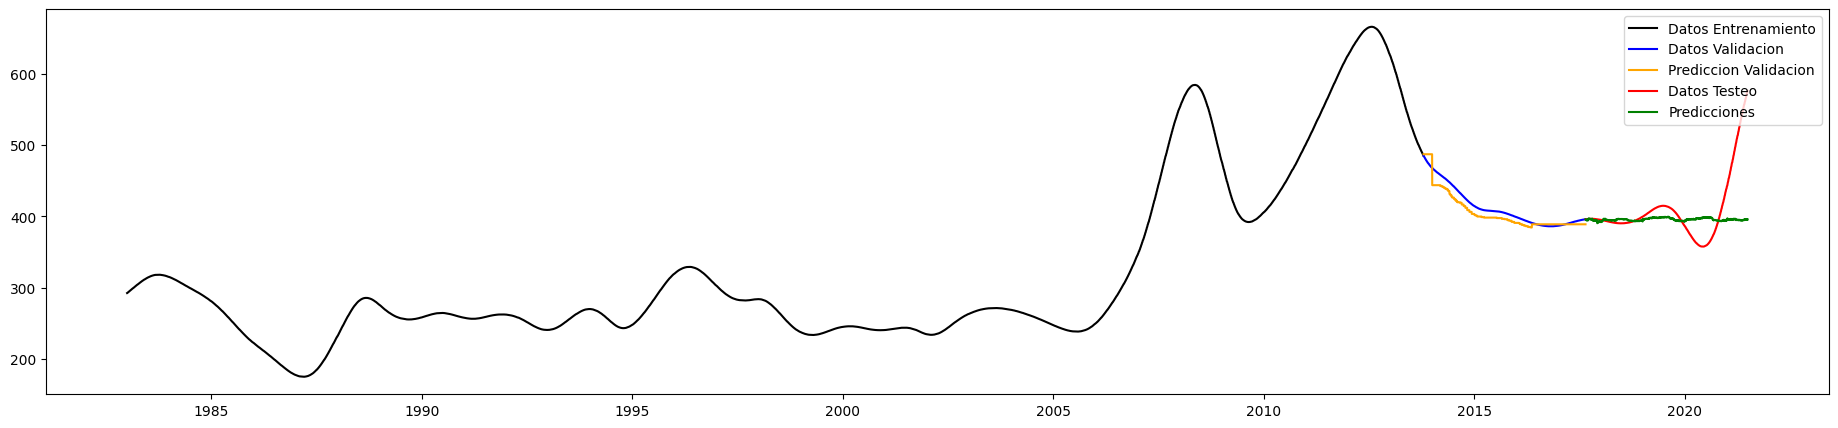

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion.index,validacion_residuo,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [ ]:
#datos_emd = modo_1.Precio_Cierre + modo_2.Precio_Cierre +modo_3.Precio_Cierre +
datos_emd =  modo_4.Precio_Cierre + modo_5.Precio_Cierre + residuo.Precio_Cierre
#predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_modo_3 +
predicciones_emd =  prediccion_modo_4 + prediccion_modo_5+ prediccion_residuo
datos_emd = datos_emd.to_frame()

In [ ]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

Metricas validacion

In [ ]:
#validacion = validacion_modo_1 + validacion_modo_2 + validacion_modo_3 +
validacion =  validacion_modo_4 + validacion_modo_5 + validacion_residuo
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.Precio_Cierre))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre)
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 15.568144524647707 
el error absoluto medio del modelo es: 12.375490146734723 
Error porcentual absoluto medio del modelo es: 0.030123128919661957


Metricas de testeo del modelo

In [ ]:
recm = np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( predicciones_emd,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 46.553222842064315 
el error absoluto medio del modelo es: 28.116496047590413 
Error porcentual absoluto medio del modelo es: 0.06907817323282031


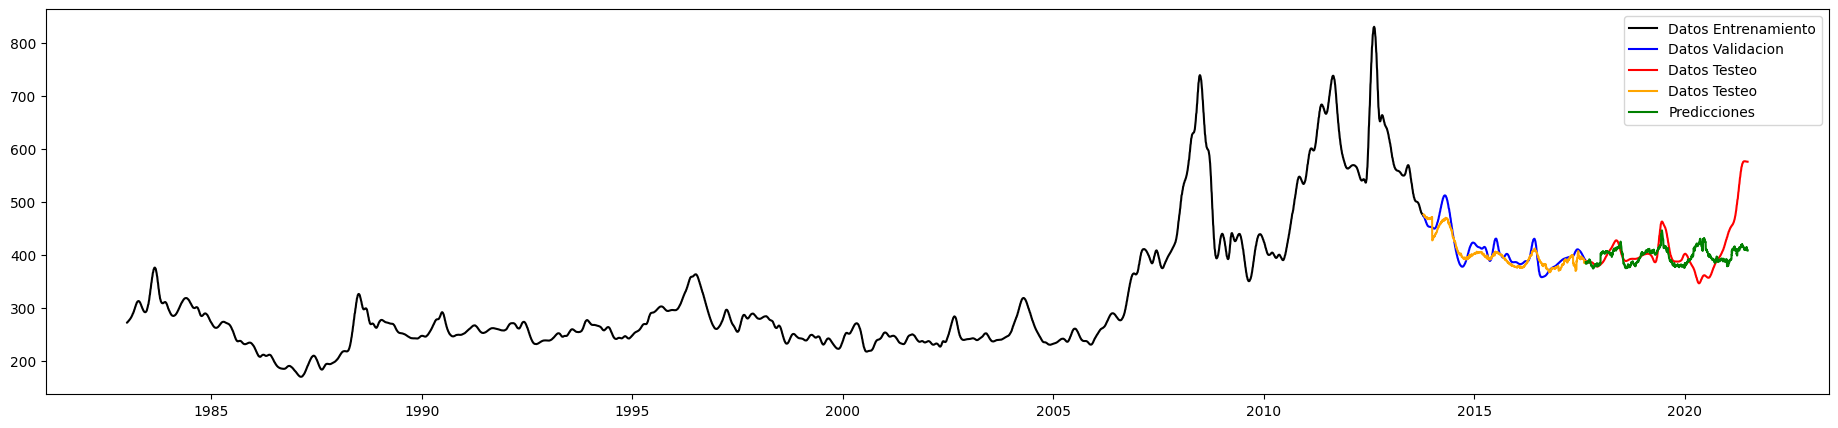

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()